In [1]:
# %%writefile score.py
# import json
# import numpy as np
# import os
# import tensorflow as tf

# from azureml.core.model import Model
# from utils import FeatureExtractor
# from accident import build_model

# def init():
#     global X, feat, sess, soft_pred, all_alphas, keep
    
#     feat = FeatureExtractor(device='cpu')
    
#     tf.reset_default_graph()
#     X,keep,y,optimizer,loss,lstm_variables,soft_pred,all_alphas = build_model(batch_size=1)
    
#     model_root = Model.get_model_path('crash-detection')
#     saver = tf.train.import_meta_graph(os.path.join(model_root, 'model/final_model.meta'))
    
#     sess = tf.Session()
#     init = tf.global_variables_initializer()
#     sess.run(init)
#     saver.restore(sess, os.path.join(model_root, 'model/final_model'))

# def run(raw_data):
#     data = np.array(json.loads(raw_data)['data'])
#     data = np.uint8(data)
        
#     # get features
#     features, boxes = feat.extract_features([data])
#     features, boxes = features[0], np.int64(boxes[0])
    
#     features = np.expand_dims(np.repeat(features[np.newaxis,...], 100, axis=0), axis=0)

#     # make prediction
#     [out, weights] = sess.run([soft_pred, all_alphas], feed_dict={X: features, keep: [0.0]})
#     y_hat = out #np.argmax(out, axis=1)
#     print("y_hat: ", y_hat)
#     return y_hat.tolist(), weights.tolist(), boxes.tolist()

In [4]:
# TEST DEPLOYMENT #

from PIL import Image
from io import BytesIO

import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import requests
import json
import cv2 
import base64

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '' 

In [6]:
def show_plot(frame, weight, bboxes):
    counter = 0
    
    new_weight = weight[:,:,0]*255
    attention_frame = np.zeros((frame.shape[0],frame.shape[1]),dtype = np.uint8)
    now_weight = new_weight[counter,:]
    new_bboxes = bboxes[:,:]
    index = np.argsort(now_weight)
    print(index)
    
    for num_box in index:
            
        if now_weight[num_box]/255.0>0.4:
            cv2.rectangle(frame,(new_bboxes[num_box,0],new_bboxes[num_box,1]),(new_bboxes[num_box,2],new_bboxes[num_box,3]),(0,255,0),3)
        else:
            cv2.rectangle(frame,(new_bboxes[num_box,0],new_bboxes[num_box,1]),(new_bboxes[num_box,2],new_bboxes[num_box,3]),(255,0,0),2)
            
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,str(round(now_weight[num_box]/255.0*10000)/10000),(new_bboxes[num_box,0],new_bboxes[num_box,1]), font, 0.5,(0,0,255),1,cv2.LINE_AA)
        attention_frame[int(new_bboxes[num_box,1]):int(new_bboxes[num_box,3]),int(new_bboxes[num_box,0]):int(new_bboxes[num_box,2])] = now_weight[num_box]

    attention_frame = cv2.applyColorMap(attention_frame, cv2.COLORMAP_HOT)
    dst = cv2.addWeighted(frame,0.6,attention_frame,0.4,0)
    cv2.putText(dst,str(counter+1),(10,30), font, 1,(255,255,255),3)
    return dst

In [7]:
%load_ext autoreload
%autoreload 2

import score

score.init()

usage: ipykernel_launcher.py [-h] [--mode MODE] [--model MODEL] [--gpu GPU]
                             [--data_dir DATA_DIR]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-8afa4d17-0c05-4e6e-b902-edc6f2966a2a.json


Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from crash-detection/model/final_model


In [8]:
url = 'https://ncadvertiser.com/wp-content/uploads/sites/82/2018/04/Cop-Car-Crash-close.jpg'

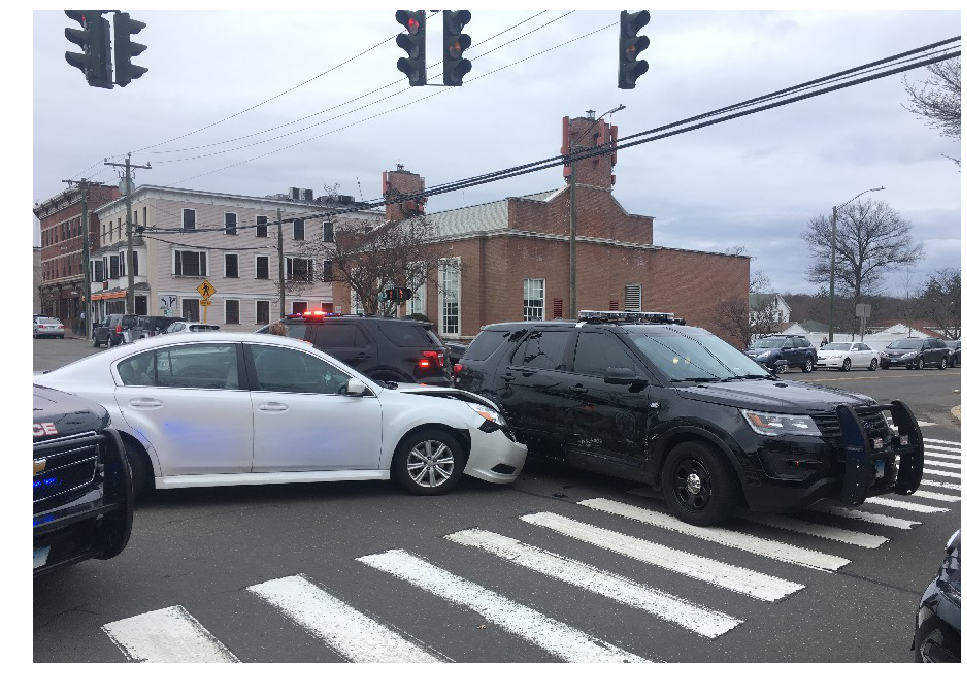

In [9]:
image = load(url)
imshow(image)

In [10]:
img_str = cv2.imencode('.jpg', image)[1].tostring()
img_str = base64.b64encode(img_str)
img_str = img_str.decode("utf-8") 

In [11]:
test_image = json.dumps({'data': img_str})
print(type(test_image))

<class 'str'>


In [12]:
test_image = bytes(test_image, encoding='utf8')

In [13]:
with open('test.byte', 'wb') as f:
    f.write(test_image)

In [20]:
%%time
result = score.run(raw_data=test_image)

CPU times: user 45.7 s, sys: 3.33 s, total: 49 s
Wall time: 2.47 s


In [15]:
prob, weight, boxes = result
weight, boxes = np.array(weight), np.array(boxes)

In [16]:
np.max(np.array(prob))

0.43767768144607544

In [17]:
weight[0,:,0]

array([6.98959993e-05, 1.26141846e-01, 9.46596992e-05, 1.00474954e-02,
       9.14560660e-05, 7.08039952e-05, 7.39193335e-03, 2.96683721e-02,
       5.18917024e-01, 9.45013962e-05, 2.27688819e-01, 5.77154458e-02,
       4.81949281e-03, 1.77399357e-04, 1.59293748e-02, 1.53870889e-04,
       2.60223198e-04, 2.59269786e-04, 4.08069522e-04])

In [58]:
boxes

array([[568,   0, 597,  76],
       [ 19, 311, 476, 478],
       [396,   0, 425,  72],
       [761, 321, 821, 349],
       [351,   0, 379,  72],
       [ 78,   3, 110,  73],
       [  1, 296,  30, 317],
       [821, 317, 890, 348],
       [416, 294, 847, 498],
       [ 30,   1,  70,  74],
       [852, 502, 898, 631],
       [693, 314, 760, 350],
       [ 56, 295,  96, 326],
       [211, 294, 414, 369],
       [  1, 359,  94, 553],
       [ 89, 298, 181, 322],
       [122, 301, 180, 313],
       [ 91, 295, 149, 318],
       [879, 318, 898, 344]])

[ 0  5  4  9  2 15 13 17 16 18 12  6  3 14  7 11  1 10  8]


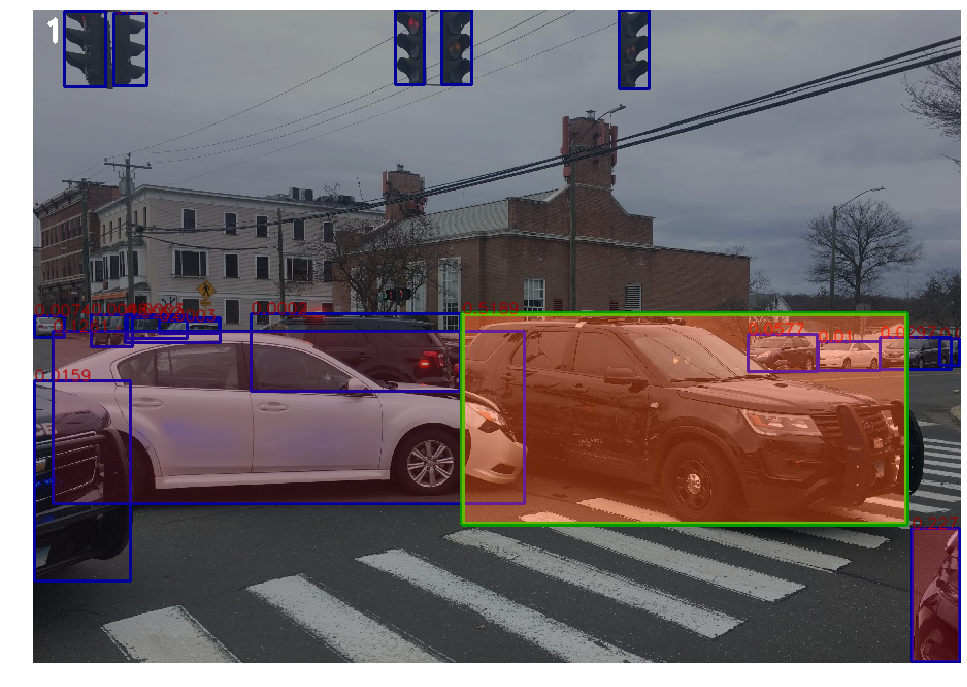

In [59]:
final_img = np.array(image.copy())
final_img = show_plot(final_img, weight, boxes)
imshow(final_img)

In [21]:
import requests

scoring_uri = 'http://128.253.51.212:8000/score'
# Set the content type
headers = { 'Content-Type':'application/json' }
# If authentication is enabled, set the authorization header
# headers['Authorization']=f'Bearer {key}'

# Make the request and display the response
resp = requests.post(scoring_uri, test_image, headers = headers)
print(resp.text)

KeyboardInterrupt: 

In [ ]:
%load_ext autoreload
%autoreload 2

from utils import FeatureExtractor
feat = FeatureExtractor('cuda')

In [ ]:
%%timeit
features, boxes = feat.extract_features([image])

In [ ]:
%%timeit
feat.coco_demo.run_on_opencv_image(image)

In [ ]:
features[0].shape

In [ ]:
boxes = boxes[0]

In [ ]:
boxes

In [31]:
zeros = np.zeros([20,1024])

In [29]:
zeros = np.expand_dims(np.repeat(zeros[np.newaxis,...], 100, axis=0), axis=0)

In [30]:
zeros.shape

(1, 100, 20, 1024)

In [46]:
%%time
np.expand_dims(np.vstack((zeros[np.newaxis,...], np.repeat(zeros[np.newaxis,...], 99, axis=0))), axis=0).shape

CPU times: user 150 ms, sys: 27.8 ms, total: 178 ms
Wall time: 14.5 ms


(1, 100, 20, 1024)